# Generating random processes in Python

### A first look at random walks
This method uses looping to introduce some basic concepts, but there are faster ways to implement this which we'll look at later.

To recap, the simple model is:

p<sub>t</sub> = p<sub>t-1</sub> + mu + u<sub>t</sub>

mu is a drift factor

u<sub>t</sub> is the price change, defined as a i.i.d. random variable

In [3]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

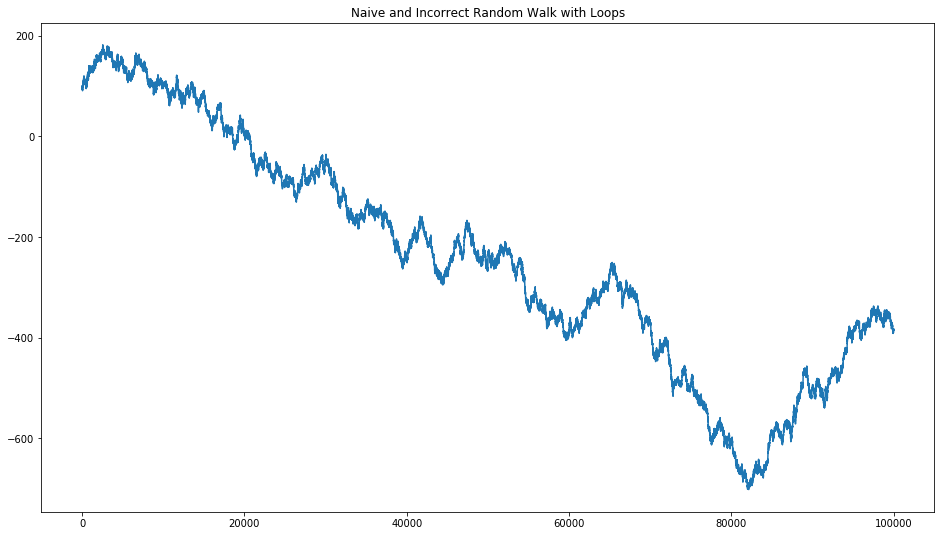

In [2]:
# basic random walk, stationary by looping.  returns a list of stock prices
n_ticks = 100000
start_price = 100.00
prices = []
prices.append(start_price)
for n in range( 1, n_ticks ):
    prices.append( prices[n-1] + np.random.normal(0, 1.0))

# let's do a simple plot of the results
figure, plot = plt.subplots(figsize=(16,9))
plot.plot( prices )
plt.title( 'Naive and Incorrect Random Walk with Loops' )
plt.show()

But that doesn't look quite right, does it?
1. We can't go negative, so let's do a product instead
2. We need to convert annualized volatility to some reasonable intraday volatility

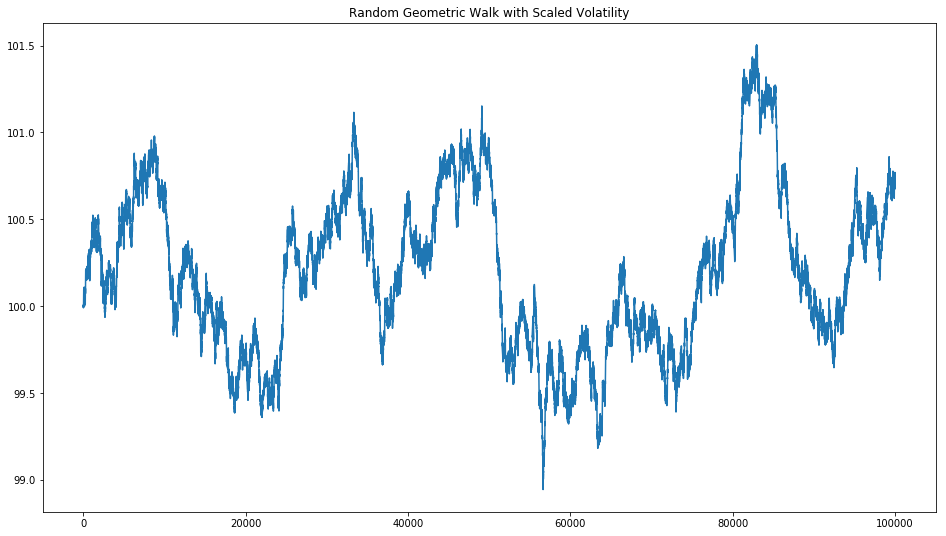

In [14]:
# random walk with scaled volatility with geometric movement 
# set up some parameters
n_ticks = 100000
start_price = 100.00
volatility = 0.20/np.sqrt( 252*390*60 )

prices = []
prices.append( start_price )

for n in range( 1, n_ticks ):
    prices.append( prices[n-1] * ( 1 + np.random.normal(0, volatility) ) )

# a simple plot of the results
figure, plot = plt.subplots(figsize=(16,9))
plot.plot( prices )
plt.title( 'Random Geometric Walk with Scaled Volatility' )
plt.show()

### A better way: leverage vector and matrix operations
This takes the same single-run model and converts it to leverage vector operations. This lays the groundwork for multi-run Monte Carlo simulations and such that will perform much better than a looping or nested looping construct.

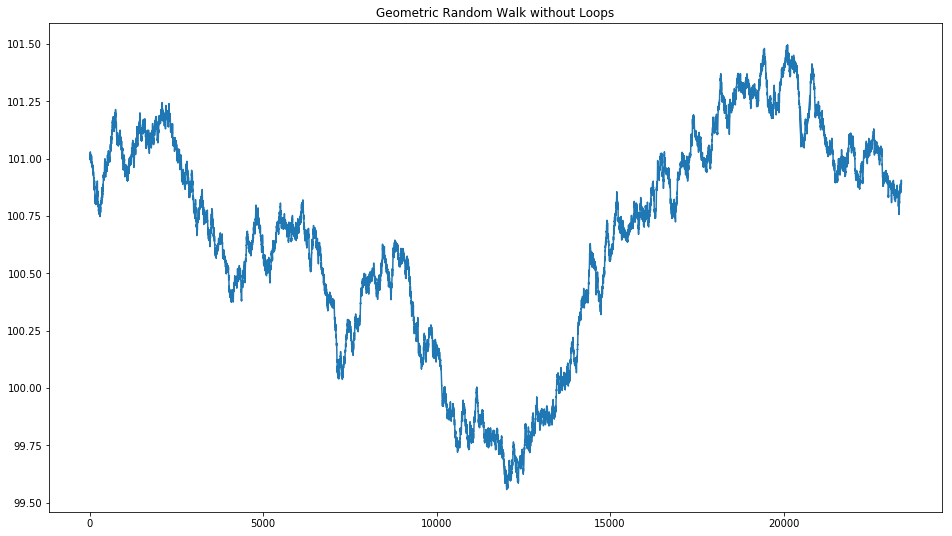

In [17]:
# random walk, matrix
n_ticks = 390 * 60
start_price = 100.0

# This is a simplistic proxy to scale intraday volatility. 
volatility = 0.20/np.sqrt( 252*390*60 ) 

# let's make a series of noise
moves = np.random.normal(0, volatility, n_ticks)

# convert it into a Series
ts = pd.Series(moves)

# throw out the first "noise" value and set our stock price to this.
ts.iloc[0] = start_price 

# add a 1.0 to our random walk series
ts = ts.add(1.0)

# calc the series
ts = ts.cumprod()

# a simple plot of the results
figure, plot = plt.subplots(figsize=(16,9))
plot.plot(ts)
plt.title('Geometric Random Walk without Loops')
plt.show()

### Adding drift
This code is the same as above, with the simple addition of a drift term. 

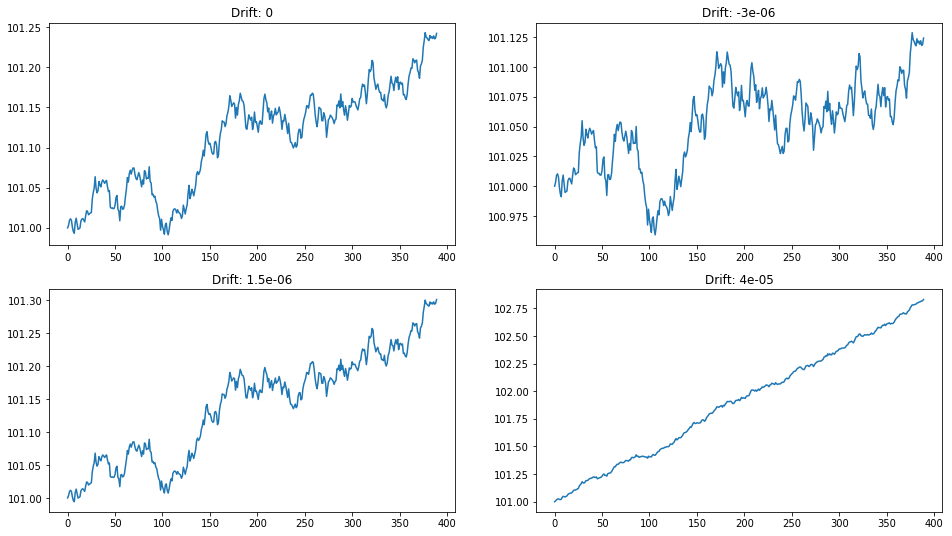

In [25]:
# random walk, matrix
n_ticks = 390
start_price = 100.0

# This is a simplistic proxy to scale intraday volatility. 
# We'll look at actually measuring it later in the course
volatility = 0.20/np.sqrt(252*390*60) 

# we want to model some trending to the data
drift1 = 0
drift2 = -3.0e-6
drift3 = 1.5e-6
drift4 = 4.0e-5

# let's make a series of noise
moves = np.random.normal(0, volatility, n_ticks)

# convert it into a Series
ts = pd.Series(moves)

# throw out the first "noise" value and set our stock price to this.
ts.iloc[0] = start_price

# add a 1.0 to our random walk series
ts = ts.add(1.0)

# add our scalar drift parameter
ts1 = ts.add(drift1)
ts2 = ts.add(drift2)
ts3 = ts.add(drift3)
ts4 = ts.add(drift4)

# calc the series
ts1 = ts1.cumprod()
ts2 = ts2.cumprod()
ts3 = ts3.cumprod()
ts4 = ts4.cumprod()

# a simple plot of the results
# this can be made into a function and optimized if you expect to re-use.

## prepare a 2x2 space on which to plot some data.
figure, plots = plt.subplots(2,2, figsize=(16,9))

## plot addresses are [row,column].  Therefore, plot[1,0] is lower-left.
plots[0,0].plot(ts1)
plots[0,0].set_title('Drift: '+ str(drift1))

plots[0,1].plot(ts2)
plots[0,1].set_title('Drift: '+ str(drift2))

plots[1,0].plot(ts3)
plots[1,0].set_title('Drift: '+ str(drift3))

plots[1,1].plot(ts4)
plots[1,1].set_title('Drift: '+ str(drift4))

plt.show()

## Monte Carlo
What if we want to understand these parameters and establish the range of outcomes over multiple iterations?

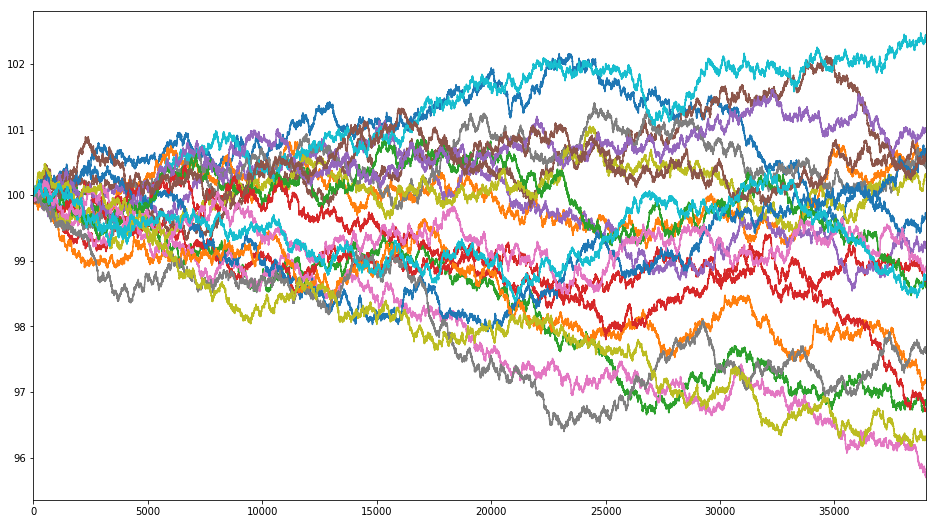

In [5]:
# monte carlo of above, matrix style
start_price = 100.0

# It's too cumbersome to create a lot of Series objects to hold each individual path.
# Thankfully, we can mix Pandas with the "size" parameter to np.random.normal()
# to build a suitable DataFrame: each row is an observation, each column is a path.

n_ticks = 390*100
n_paths = 20

volatility = 0.20/np.sqrt( 252*390*60 )
#volatility *= 2

drift = 0
#drift = -4.0e-6

df = pd.DataFrame( np.random.normal( 0 , volatility , size=( n_ticks , n_paths ) ) )
df = df.add(1.0)
df = df.add(drift)

# set the appropriate start price, aka the first value of each path
df.iloc[0] = start_price

# same as above
df_p = df.cumprod()

# Use the builtin Pandas plotting functionality to do the dirty work for us
df_p.plot(legend=False, figsize = (16,9))
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000C71B048>]],
      dtype=object)

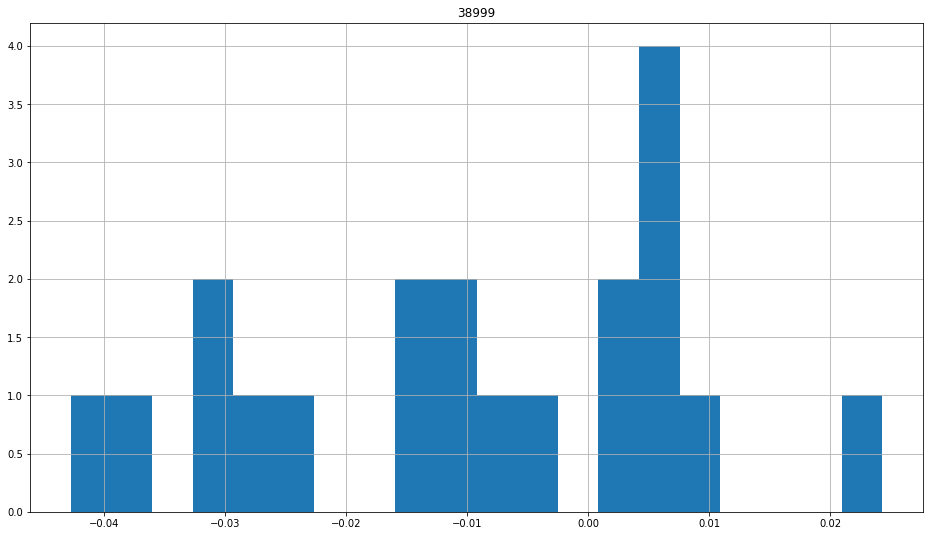

In [6]:
# now let's plot the returns in a histogram

total_pct_change = df_p.diff().cumsum() / df_p.iloc[0]
total_pct_change = total_pct_change.tail(1).transpose()
total_pct_change.hist(bins=20,figsize=(16,9))